## Algoritms #3
## Классификация. Логистическая регрессия.

* [Минимизация  log loss подбором аргументов функции eval_model](#minlog)
* [calc_pred_proba (вероятность класса 1), calc_pred (предсказание класса)](#proba)
* [Accuracy, матрица ошибок, точность, полнота, F1 score](#f1)
* [eval_model_l1, eval_model_l2 с применением L1 и L2 регуляризаций](#l1l2)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import sklearn.linear_model
np.random.seed(42)
%matplotlib inline

1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

`Ответ` дописана функция fix_zeros (описана в основном блоке кода), которая расширяет границу задания alpha

2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

6. Могла ли модель переобучиться? Почему?

`Ответ` Да, в виду отсутствия кросс-валидации модель могла переобучиться и просто запомнить результаты. Большое число итераций и подбор альфа на тренеровочных данных способствует переобучению и небольшие изменения на тестовых данных вероятнее всего покажут ниже результат. Переобучение будет более заметно проявляться, если усложнить модель и добавить шум.

7. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [5]:
# X[0] - wghts
# X[1] - exp, years
# X[2] - cost
# X[3] - qualify

X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2,  1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [6]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

def fix_zeros(y_pred):
    res = []
    for y in y_pred:
        if y < 1e-8:
            y = 1e-8
        res.append(y)       
    return np.array(res, dtype=np.float64)
        

def calc_logloss(y, y_pred):
    
    y_pred = fix_zeros(y_pred) # фикс (всё ещё имеет проблемы на очень малых значениях y_pred)    
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    err = np.sum(err)
    return err

def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

# LR eval
def eval_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        if i % (iterations / 10) == 0:
            # print(i, W, err)
            pass
    return W

X_st = X.copy()
X_st[2, :] = calc_std_feat(X[2, :])

In [7]:
# проверка работы алгоритма с нулевым input
y1 = np.array([1, 0])
y_pred1 = np.array([0.99, 0])
calc_logloss(y1, y_pred1)

0.005025172926750776

## <left>Минимизация  log loss подбором аргументов функции eval_model<a class="anchor" id="minlog"></a><left>

In [5]:
def eval_model_err(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        if i % (iterations / 10) == 0:
            # print(i, W, err)
            pass
    return err # для улучшения работы с памятью возвращает только ошибку

# Подбор лучших параметров
alphas = np.linspace(1e-8, 5, 300)
# min_alpha = np.inf
err_pred = np.inf
for a in alphas:
    err = eval_model_err(X_st, y, iterations=5000, alpha=a)
    if err < err_pred:
        err_pred = err
        min_alpha = a
print(f'last err_pred: {err_pred}, min_alpha: {min_alpha}')

last err_pred: 0.08053363155615358, min_alpha: 4.983277592006688


## <left>calc_pred_proba (вероятность класса 1), calc_pred (предсказание класса)<a class="anchor" id="proba"></a><left>

In [8]:
def calc_pred_proba(W,X):
    z = np.dot(W, X)
    y_pred_proba = sigmoid(z)
    return y_pred_proba

In [9]:
W = eval_model(X_st, y, iterations=5000, alpha=1e-2)
calc_pred_proba(W, X_st)

array([0.33792862, 0.41735882, 0.77246141, 0.0154879 , 0.81700825,
       0.6787608 , 0.89471594, 0.17162867, 0.31923991, 0.8383367 ])

In [10]:
W = eval_model(X_st, y, iterations=5000, alpha=0.1)
W

array([-7.45498358, -1.13935179, -1.38026181,  6.55264038])

In [11]:
def calc_pred(W, X):
    proba = calc_pred_proba(W,X)
    y_pred = [1 if x>0.5 else 0 for x in proba]
    return np.array(y_pred)

In [12]:
y

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1.])

In [13]:
y_pred = calc_pred(W, X_st)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

## <left>Accuracy, матрица ошибок, точность, полнота, F1 score<a class="anchor" id="f1"></a><left>

In [14]:
accuracy = np.sum(y == y_pred)/len(y)
accuracy

0.9

In [15]:
def calc_rates(y, y_pred):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y)):
        if y_pred[i] == 1 and y[i] == 1:
            TP +=1
        if y[i] == 0 and y_pred[i] == 1:
            FP +=1
        if y[i] == 1 and y_pred[i] == 0:
            FN +=1
        if y[i] == 0 and y_pred[i] == 0:
            TN +=1
    return TP, FP, FN, TN

In [17]:
TP, FP, FN, TN = calc_rates(y, y_pred)
print(f'TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}')

TP: 4, FP: 0, FN: 1, TN: 5


In [21]:
precision = TP / (TP + FP)
precision

1.0

In [22]:
recall = TP / (TP + FN)
recall

0.8

$$F_{\beta} = (1 + \beta^{2}) \frac{precision \cdot recall}{\beta^{2} \cdot precision + recall}.$$

In [24]:
f1 = (2 * precision * recall) / (precision + recall)
f1

0.888888888888889

In [20]:
from sklearn.metrics import f1_score

f1_score(y, y_pred)

0.888888888888889

In [49]:
confusion_matrix(y, calc_pred(W, X_st))

array([[5, 0],
       [1, 4]], dtype=int64)

[[5 0]
 [1 4]]


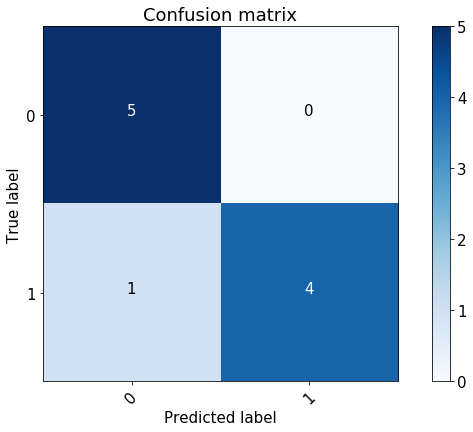

In [50]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y, calc_pred(W, X_st))
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

## <left>eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций<a class="anchor" id="l1l2"></a><left>

In [27]:
def eval_model_l1(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) + lambda_ * np.sign(W))
        if i % (iterations / 10) == 0:
            # print(i, W, err)
            pass
    return W

def eval_model_l2(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) + lambda_ * W)
        if i % (iterations / 10) == 0:
            # print(i, W, err)
            pass
    return W

In [28]:
W1 = eval_model_l1(X_st, y, iterations=5000, alpha=1e-2)
W2 = eval_model_l2(X_st, y, iterations=5000, alpha=1e-2)
print(W1)
print(W2)

[-1.33877797 -0.91225112  0.82169031  2.38340996]
[-1.2975622  -0.92200247  0.85647834  2.37529338]
